In [1]:
import os 
import re 
from scipy import ndimage, misc 
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import img_to_array


from skimage.transform import resize, rescale
import matplotlib.pyplot as plt
import numpy as np
np. random. seed(0)
import cv2 as cv2

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense ,Conv2D,MaxPooling2D ,Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
import tensorflow as tf

print(tf.__version__)

2.8.2


In [2]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
high_img = []
path = '/content/drive/MyDrive/project/MMS project/dataset/Raw Data/high_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '855.png':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))
low_img = []
path = '/content/drive/MyDrive/project/MMS project/dataset/Raw Data/low_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
    if i == '855.png':
        break
    else: 
        img = cv2.imread(path + '/'+i,1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))

100%|██████████| 855/855 [00:13<00:00, 65.52it/s] 


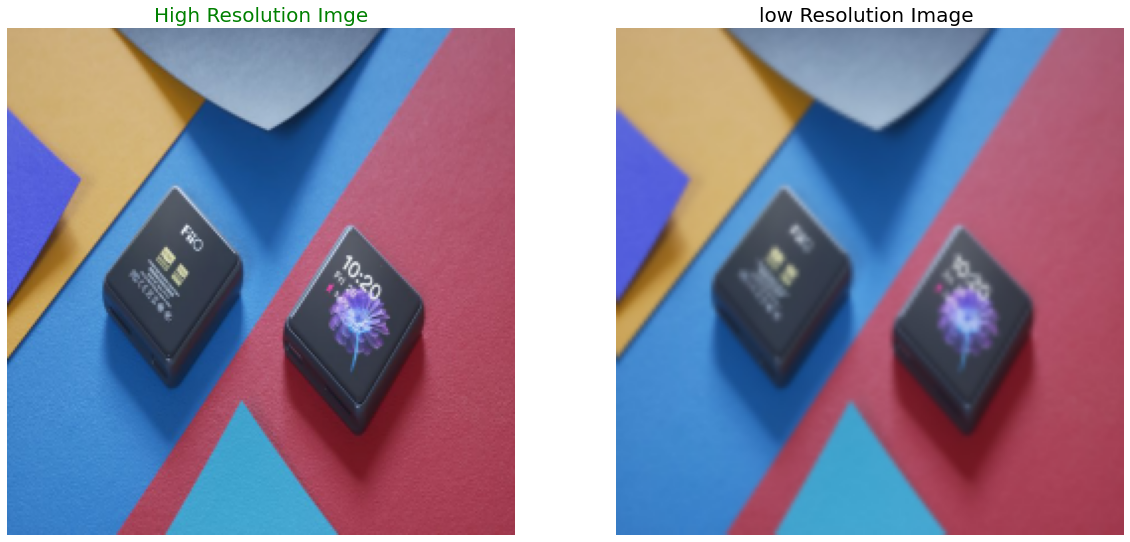

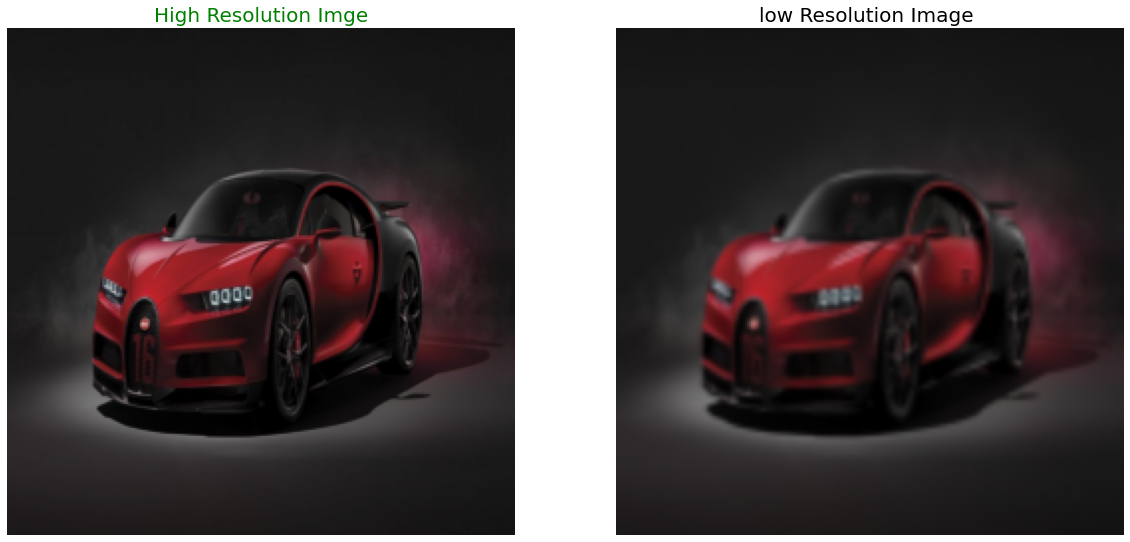

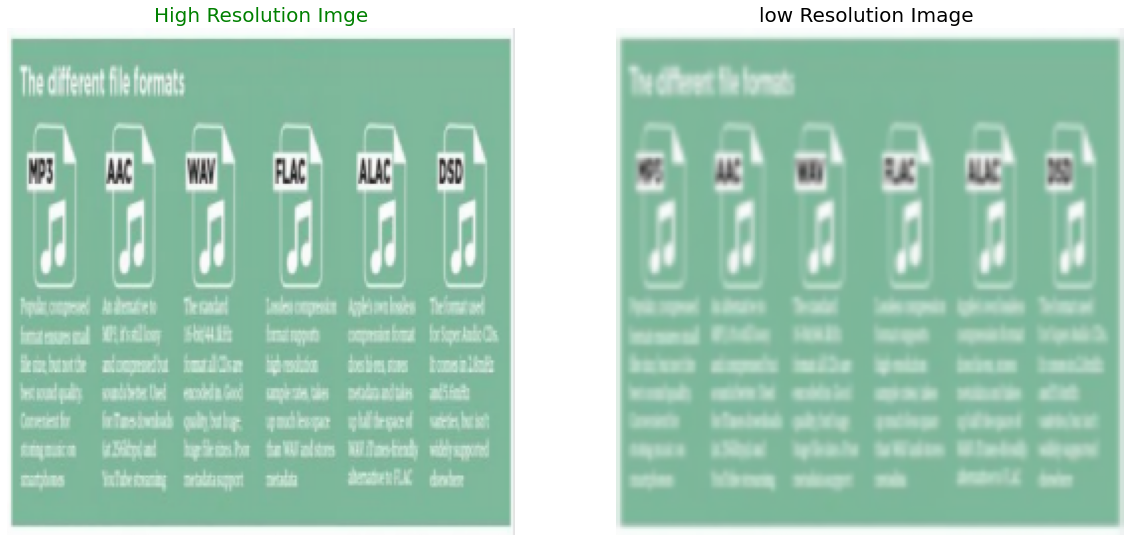

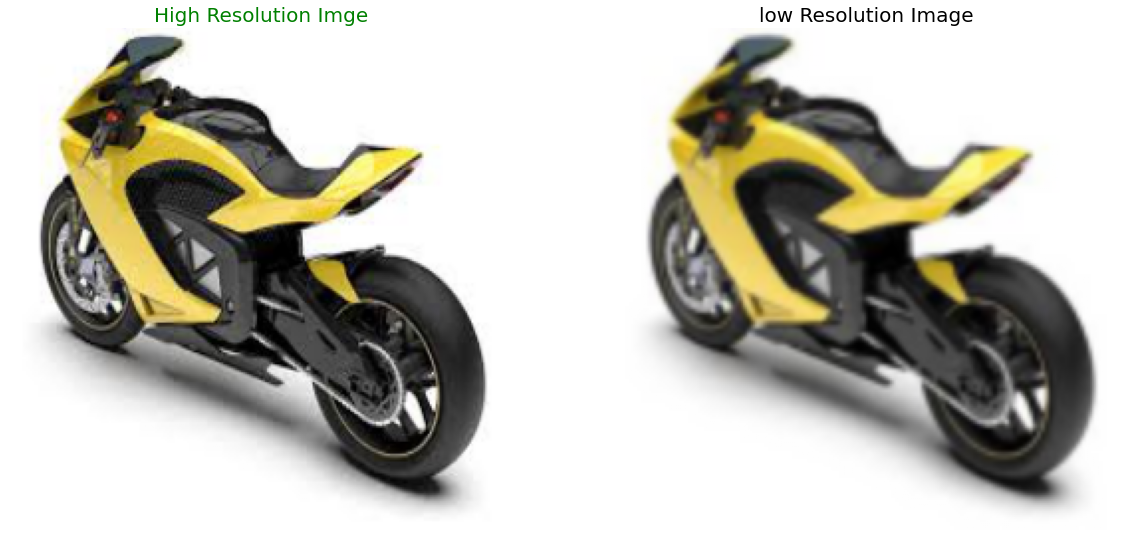

In [3]:
for i in range(4):
    a = np.random.randint(0,99)
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(low_img[a])
    plt.axis('off')

In [4]:
train_high_image = high_img[:700]
train_low_image = low_img[:700]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

validation_high_image = high_img[700:830]
validation_low_image = low_img[700:830]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))


test_high_image = high_img[830:]
test_low_image = low_img[830:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)

Shape of training images: (700, 256, 256, 3)
Shape of test images: (25, 256, 256, 3)
Shape of validation images: (130, 256, 256, 3)


In [5]:
input_img=Input(shape=(256,256,3))
l1=Conv2D (64,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(input_img)
l2=Conv2D (128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l1)
l3=Conv2D (256,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l2)
l4=Conv2D (128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l3)
l5=Conv2D (64,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l4)
output=Conv2D (3,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l5)

CNN_model=Model(input_img,output)
CNN_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 256)     295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 128)     295040    
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 256, 64)      73792     
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 3)       1731  

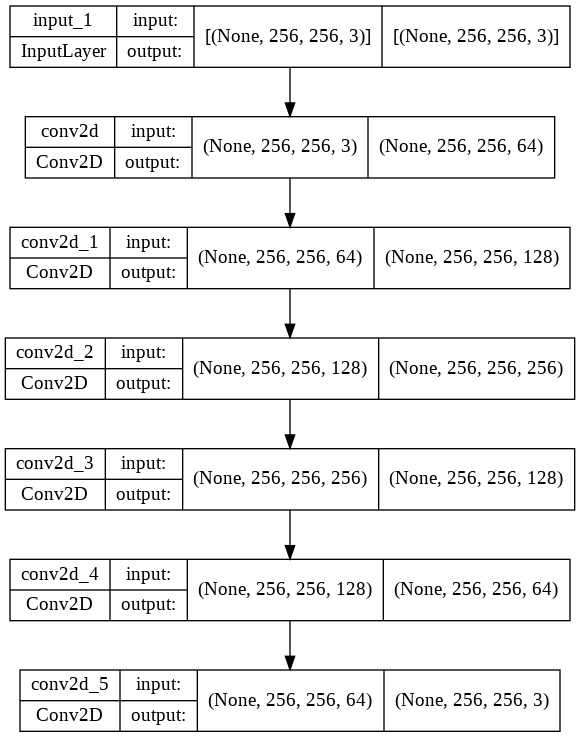

In [6]:
tf.keras.utils.plot_model(CNN_model, to_file="model2.png", show_shapes=True)

In [7]:
CNN_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

In [10]:
es=tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=3)

In [11]:
history=CNN_model.fit(train_low_image, train_high_image, epochs = 50, batch_size = 1,
          validation_data = (validation_low_image,validation_high_image),callbacks=[es])

Epoch 1/50
700/700 [==============================] - 48s 69ms/step - loss: 0.0354 - acc: 0.7208 - val_loss: 0.0762 - val_acc: 0.7373
Epoch 2/50
700/700 [==============================] - 45s 64ms/step - loss: 0.0363 - acc: 0.7176 - val_loss: 0.0340 - val_acc: 0.7795
Epoch 3/50
700/700 [==============================] - 45s 65ms/step - loss: 0.0367 - acc: 0.7094 - val_loss: 0.0375 - val_acc: 0.7360
Epoch 4/50
700/700 [==============================] - 45s 65ms/step - loss: 0.0307 - acc: 0.7479 - val_loss: 0.0292 - val_acc: 0.8186
Epoch 5/50
700/700 [==============================] - 45s 64ms/step - loss: 0.0339 - acc: 0.7439 - val_loss: 0.0377 - val_acc: 0.7760
Epoch 6/50
700/700 [==============================] - 48s 68ms/step - loss: 0.0320 - acc: 0.7526 - val_loss: 0.0284 - val_acc: 0.7581
Epoch 7/50
700/700 [==============================] - 48s 68ms/step - loss: 0.0309 - acc: 0.7520 - val_loss: 0.0337 - val_acc: 0.7107
Epoch 8/50
700/700 [==============================] - 48s 68ms

In [12]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


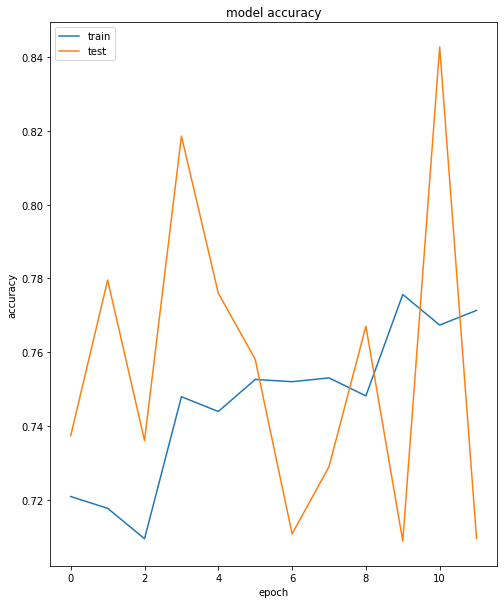

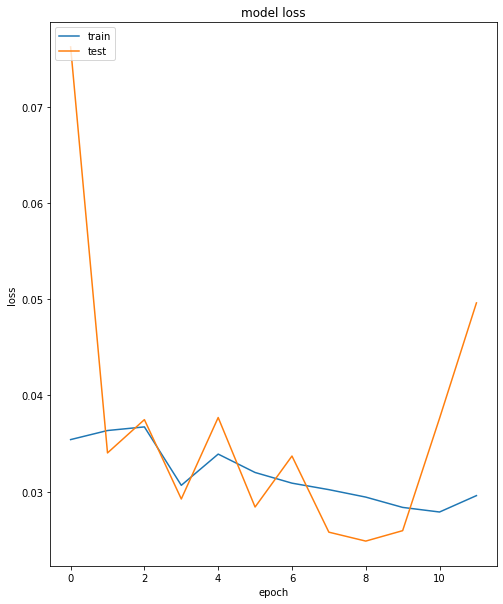

In [15]:
plt.figure(figsize=(8,10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('modelaccuracy.png')
plt.show()

# summarize history for loss
plt.figure(figsize=(8,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show
plt.savefig('modelloss.png')

In [16]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def SSIM(train_low_image,train_high_image):
  return ssim(train_low_image,train_high_image,multichannel=True) 
def PSNR(y_true,y_pred):
  return psnr(y_true,y_pred) 


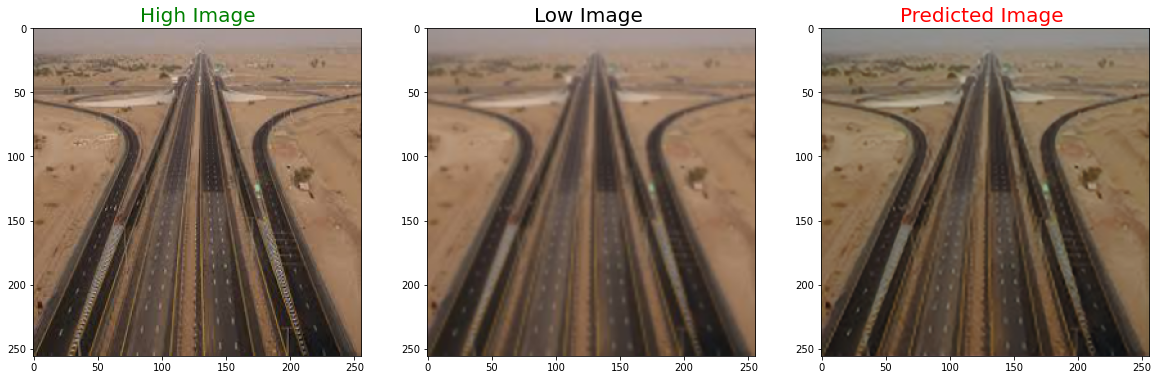

SSIM 0.9182914376523685
PSNR 24.974210112379403 dB


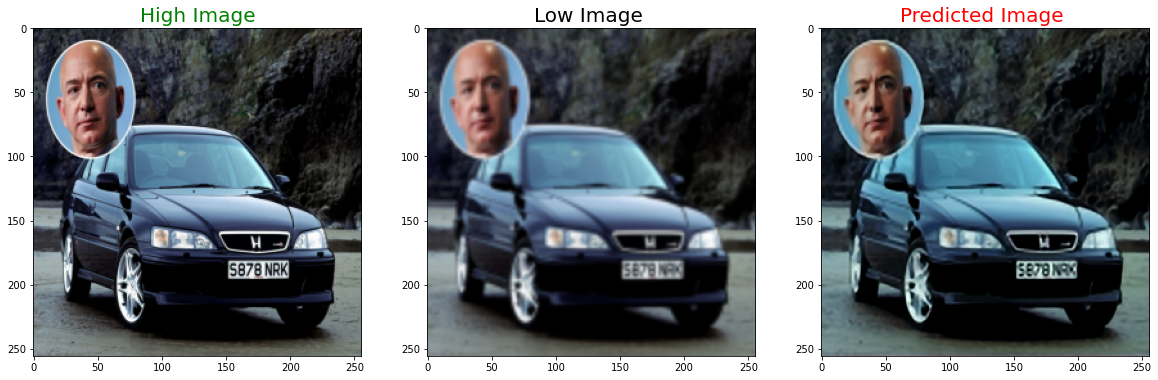

SSIM 0.9224511013785651
PSNR 24.53215713188316 dB


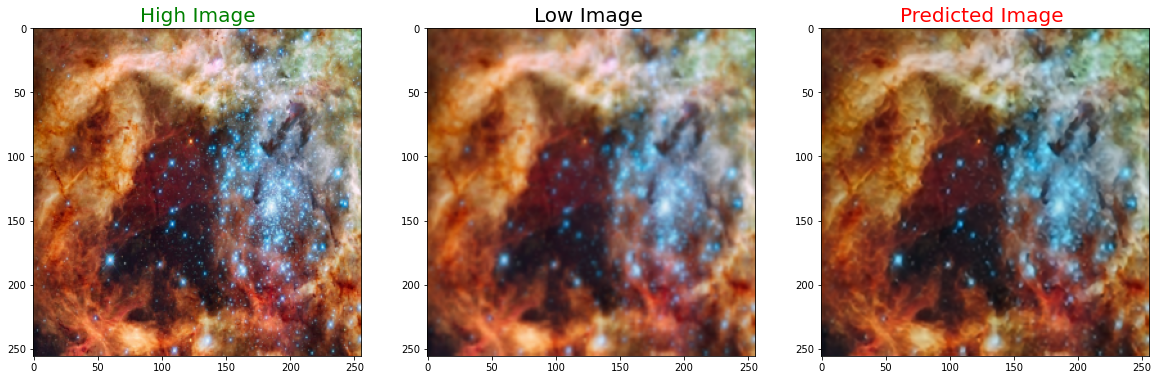

SSIM 0.8805766286682903
PSNR 23.26731035484979 dB


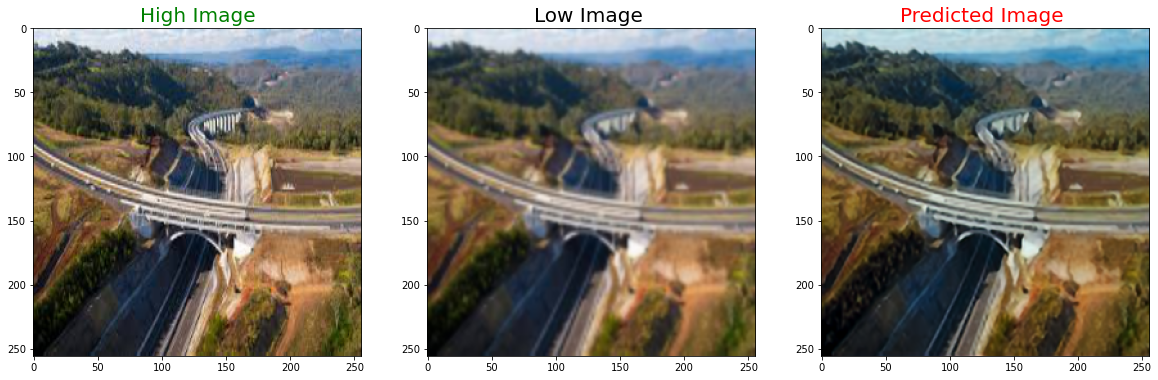

SSIM 0.9131688190165743
PSNR 23.9096376262384 dB


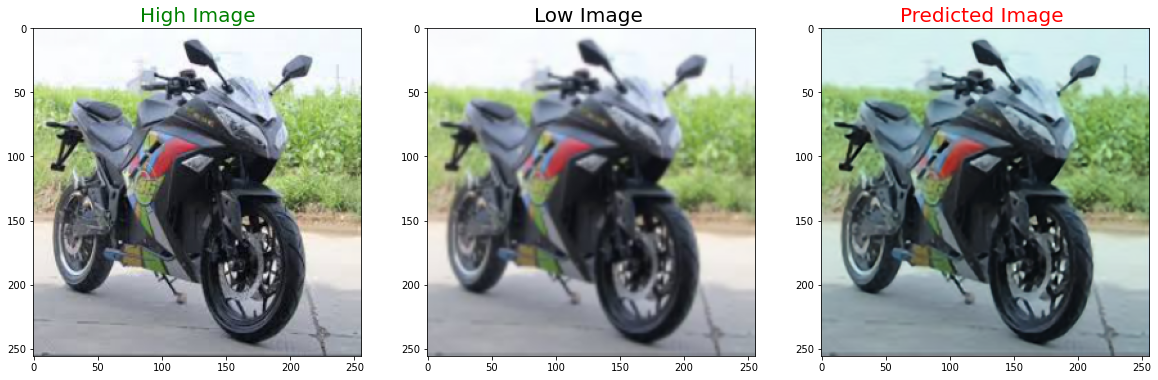

SSIM 0.945722014714026
PSNR 22.99495181030742 dB


In [18]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
    plt.savefig('pred'+str(i)+'.png') 
    plt.show()

for i in range(0,5):
    
    predicted = np.clip(CNN_model.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_high_image[i],test_low_image[i],predicted)
    print('SSIM',SSIM(test_high_image[i],predicted))
    print('PSNR',PSNR(test_high_image[i],predicted),'dB')

In [ ]:
CNN_model.save("model21.h5")